### Finance

In [3]:
# 먼저 필요한 library를 불러오자

import pandas_datareader as pdr
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
!pip install pandas_datareader
!pip install yfinance

In [3]:
#cybos랑 연결이 되었는지 확인
import win32com.client
cy = win32com.client.Dispatch("CpUtil.CpCybos")
print ( cy.IsConnect )

1


In [4]:
#주피터 설정이 32bit인지 확인
import platform
print(platform.architecture())

('32bit', 'WindowsPE')


### 시가총액 3000억 이상이며 1/PER(=기대수익률) > 0.15 이상 그리고 PBR < 1.0 이하이면서 ROE>0.20, 자산가치가 현재 주가보다 높은 종목 찾기

In [7]:
# find valuable items
import win32com.client
 
# declare Cybosplus API
cpStockCode = win32com.client.Dispatch("CpUtil.CpStockCode")
cpStockMst = win32com.client.Dispatch("dscbo1.StockMst") # not CpDib.StockMst
 
# total num of stock items
itNum = cpStockCode.GetCount()
print(itNum)
 
for it in range(0, itNum):
 
   # get item info
    itCode = cpStockCode.GetData(0, it)
    itName = cpStockCode.GetData(1, it)
 
   # request info
    cpStockMst.SetInputValue(0, itCode)
    cpStockMst.BlockRequest()
    
   # get header values
    managedStatus = chr(cpStockMst.GetHeaderValue(66)) # 관리구분
    alarmInvestStatus = chr(cpStockMst.GetHeaderValue(67)) # 투자 경고 구분
    tradeStopStatus = chr(cpStockMst.GetHeaderValue(68)) # 거래 정지 구분
    unfaithfulNoticeStatus = chr(cpStockMst.GetHeaderValue(69)) # 불성실 공시 구분
    exchangeType = chr(cpStockMst.GetHeaderValue(45)) # 소속구분 '1' : 거래소, '5': 코스닥
 
   # filtering items
    if managedStatus == 'N' and alarmInvestStatus == '1' and tradeStopStatus == 'N' and unfaithfulNoticeStatus == '0':
        if exchangeType == '1' or exchangeType == '5':
            currentPrice = int(cpStockMst.GetHeaderValue(11)) # current price (현재가)
            stockNum = int(cpStockMst.GetHeaderValue(31)) # 발행주식수
            marketCap = currentPrice * stockNum
            EPS = float(cpStockMst.GetHeaderValue(20)) # EPS
            BPS = float(cpStockMst.GetHeaderValue(70)) # BPS
            PER = float(cpStockMst.GetHeaderValue(28)) # PER
            # ROE=PBR/PER
            if BPS != 0:
                PBR = float(currentPrice/BPS) # PBR calculation
            else:
                PBR = float('inf')
            assetValue = BPS

            profitValue = EPS / 0.01 # 10% 할인률 적용
            eValue = (assetValue * 2 + profitValue * 3) / 5
            if marketCap > 300000000000 and PER != 0 and 1 / PER > 0.15 and PBR < 1.0 and PBR/PER >0.20:
                if eValue > currentPrice:
                    print(itName + "<" + itCode + ">")

3558
동아쏘시오홀딩스<A000640>
코오롱<A002020>
코오롱글로벌<A003070>
대신증권<A003540>
GS리테일<A007070>
F&F홀딩스<A007700>
KTB투자증권<A030210>
서희건설<A035890>
키움증권<A039490>
한국금융지주<A071050>
티케이케미칼<A104480>


KeyboardInterrupt: 

In [86]:
# 주가 데이터를 불러오자  
# (yahoo finance open API, 공식적으로 없어졌지만, 비공식적으로 서비스는 제공되고 있음)

start = datetime(2020,9,1)
end = datetime(2021,6,30)
#end = datetime.today()

##aapl = pdr.DataReader('AAPL', 'yahoo', start, end) # APPLE  

ss = pdr.DataReader('005930.KS','yahoo',start,end) # Samsung Electronics Co., Ltd. (원화 표시 KRW)

In [87]:
ss

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-09-01,54800.0,54100.0,54100.0,54200.0,19363117.0,51836.722656
2020-09-02,55100.0,54100.0,54600.0,54400.0,16905723.0,52028.011719
2020-09-03,56700.0,55500.0,55600.0,56400.0,28384920.0,53940.800781
2020-09-04,55800.0,55100.0,55200.0,55600.0,22139109.0,53175.683594
2020-09-07,57300.0,55800.0,56100.0,56500.0,18685880.0,54036.437500
...,...,...,...,...,...,...
2021-06-24,81400.0,80100.0,80400.0,81200.0,18771080.0,80459.601562
2021-06-25,81900.0,81200.0,81500.0,81600.0,13481405.0,80855.953125
2021-06-28,82000.0,81600.0,81700.0,81900.0,11578529.0,81153.218750


<AxesSubplot:xlabel='Date'>

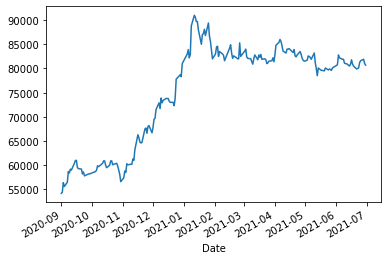

In [88]:
ss['Close'].plot()

In [89]:
# Initialize the short and long windows
short_window = 20
long_window = 80

# Initialize the `signals` DataFrame with the `signal` column
signals = pd.DataFrame(index=ss.index)
signals['signal'] = 0.0

# Create short simple moving average over the short window
signals['short_mavg'] = ss['Close'].rolling(window=short_window, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
signals['long_mavg'] = ss['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

# 투자전략 : 단기균형 > 장기균형  ==>  Buy 
# 투자전략 : 단기균형 < 장기균형  ==>  Sell 
# Create signals
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                            > signals['long_mavg'][short_window:], 1.0, 0.0)   

# Generate trading orders
signals['positions'] = signals['signal'].diff()

# Print `signals`
print(signals)

            signal  short_mavg  long_mavg  positions
Date                                                
2020-09-01     0.0     54200.0   54200.00        NaN
2020-09-02     0.0     54300.0   54300.00        0.0
2020-09-03     0.0     55000.0   55000.00        0.0
2020-09-04     0.0     55150.0   55150.00        0.0
2020-09-07     0.0     55420.0   55420.00        0.0
...            ...         ...        ...        ...
2021-06-24     0.0     80985.0   81873.75        0.0
2021-06-25     0.0     81060.0   81843.75        0.0
2021-06-28     0.0     81130.0   81837.50        0.0
2021-06-29     0.0     81150.0   81823.75        0.0
2021-06-30     0.0     81145.0   81807.50        0.0

[205 rows x 4 columns]


<AxesSubplot:xlabel='Date'>

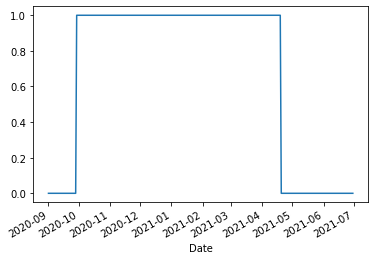

In [90]:
signals.signal.plot()

<AxesSubplot:xlabel='Date'>

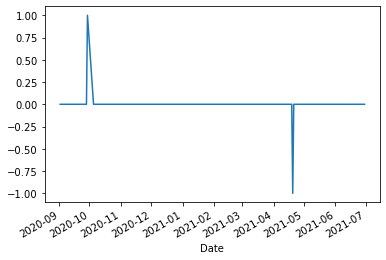

In [91]:
signals.positions.plot()

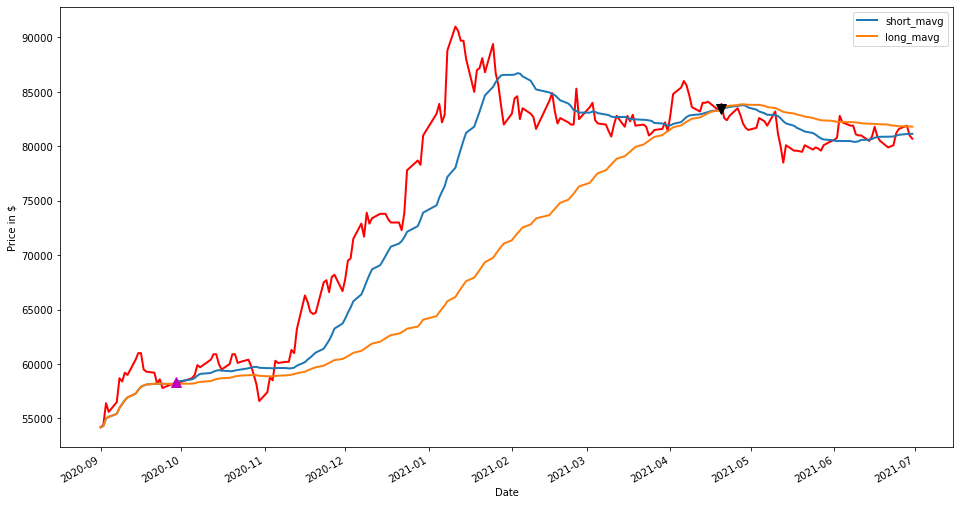

In [103]:

# Initialize the plot figure
fig = plt.figure(figsize=(16,9))

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,  ylabel='Price in $')

# Plot the closing price
ss['Close'].plot(ax=ax1, color='r', lw=2.)

# Plot the short and long moving averages
signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)

# Plot the buy signals
ax1.plot(signals.loc[signals.positions == 1.0].index, 
         signals.short_mavg[signals.positions == 1.0],
         '^', markersize=10, color='m')
         
# Plot the sell signals
ax1.plot(signals.loc[signals.positions == -1.0].index, 
         signals.short_mavg[signals.positions == -1.0],
         'v', markersize=10, color='k')
         
# Show the plot
plt.show()

## 성과평가

In [93]:
# Set the initial capital
initial_capital= float(10000000.0)

# Create a DataFrame `positions`
positions = pd.DataFrame(index=signals.index).fillna(0.0)

# Buy a 100 shares
positions['SS'] = 100*signals['signal']   
  
# Initialize the portfolio with value owned   
portfolio = positions.multiply(ss['Close'], axis=0)


# Store the difference in shares owned 
pos_diff = positions.diff()

# Add `holdings` to portfolio
portfolio['holdings'] = (positions.multiply(ss['Close'], axis=0)).sum(axis=1)

# Add `cash` to portfolio 
# (실제 거래에서는 Close로 하는게 맞아요. Adj Close 는 나중에 따로 계산되기 때문)
portfolio['cash'] = initial_capital - (pos_diff.multiply(ss['Close'], axis=0)).sum(axis=1).cumsum()   

# Add `total` to portfolio
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# Add `returns` to portfolio
portfolio['returns'] = portfolio['total'].pct_change()*100

# 참고로 종가 및 종가수익률도 첨가해요 (성과평가를 위해서 )
portfolio['Close'] = ss['Close']
portfolio['ret_Close'] = ss['Close'].pct_change()*100

portfolio['ret_position'] = portfolio['ret_Close'].mul(signals['signal'])
portfolio['signal'] =signals['signal']
portfolio['positions'] =signals['positions']

# Print the first lines of `portfolio`
print(portfolio)

             SS  holdings        cash       total  returns    Close  \
Date                                                                  
2020-09-01  0.0       0.0  10000000.0  10000000.0      NaN  54200.0   
2020-09-02  0.0       0.0  10000000.0  10000000.0      0.0  54400.0   
2020-09-03  0.0       0.0  10000000.0  10000000.0      0.0  56400.0   
2020-09-04  0.0       0.0  10000000.0  10000000.0      0.0  55600.0   
2020-09-07  0.0       0.0  10000000.0  10000000.0      0.0  56500.0   
...         ...       ...         ...         ...      ...      ...   
2021-06-24  0.0       0.0  12570000.0  12570000.0      0.0  81200.0   
2021-06-25  0.0       0.0  12570000.0  12570000.0      0.0  81600.0   
2021-06-28  0.0       0.0  12570000.0  12570000.0      0.0  81900.0   
2021-06-29  0.0       0.0  12570000.0  12570000.0      0.0  81000.0   
2021-06-30  0.0       0.0  12570000.0  12570000.0      0.0  80700.0   

            ret_Close  ret_position  signal  positions  
Date               

<AxesSubplot:xlabel='Date'>

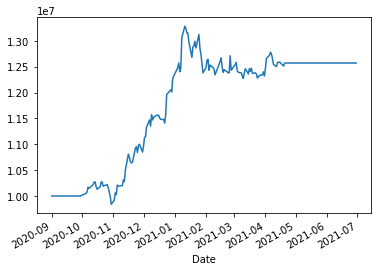

In [94]:
portfolio.total.plot()

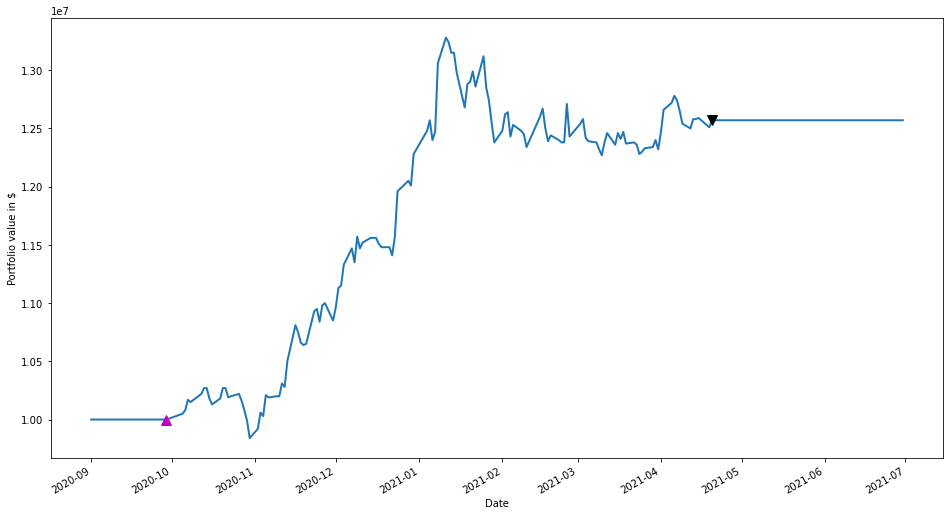

In [95]:
# Import the `pyplot` module as `plt`
#import matplotlib.pyplot as plt

# Create a figure
fig = plt.figure(figsize=(16,9))

ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')

# Plot the equity curve in dollars
portfolio['total'].plot(ax=ax1, lw=2.)

ax1.plot(portfolio.loc[signals.positions == 1.0].index, 
         portfolio.total[signals.positions == 1.0],
         '^', markersize=10, color='m')
ax1.plot(portfolio.loc[signals.positions == -1.0].index, 
         portfolio.total[signals.positions == -1.0],
         'v', markersize=10, color='k')

# Show the plot
plt.show()

### Sharpe Ratio

In [96]:
# Isolate the returns of your strategy
returns = portfolio['returns']

# annualized Sharpe ratio
sharpe_ratio = np.sqrt(252) * (returns.mean() / returns.std())

# Print the Sharpe ratio
print(sharpe_ratio)

2.0310225120209986


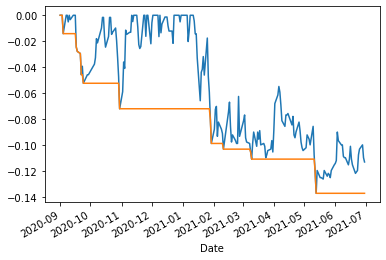

In [97]:
# Define a trailing 252 trading day window
window = 252

# Calculate the max drawdown in the past window days for each day 
rolling_max = ss['Close'].rolling(window, min_periods=1).max()
daily_drawdown = ss['Close']/rolling_max - 1.0

# Calculate the minimum (negative) daily drawdown
max_daily_drawdown = daily_drawdown.rolling(window, min_periods=1).min()

# Plot the results
daily_drawdown.plot()
max_daily_drawdown.plot()

# Show the plot
plt.show()

**Compound Annual Growth Rate (CAGR)**

$EV$: the investment's ending value 

$BV$: the investment's beginning value 

$n$: the number of periods

$(EV/BV)^{1/n}−1$

In [98]:
# Get the number of days in `ss`
days = (ss.index[-1] - ss.index[0]).days

# Calculate the CAGR 
cagr = (((((ss['Close'][-1]) / ss['Close'][0])) ** (365.0/days)) - 1 )*100

# Print the CAGR (%)
print(cagr)

61.78468928233496


In [99]:
portfolio

,SS,holdings,cash,total,returns,Close,ret_Close,ret_position,signal,positions
Date,,,,,,,,,,
2020-09-01,0.0,0.0,10000000.0,10000000.0,NaN,54200.0,NaN,NaN,0.0,NaN
2020-09-02,0.0,0.0,10000000.0,10000000.0,0.0,54400.0,0.369004,0.0,0.0,0.0
2020-09-03,0.0,0.0,10000000.0,10000000.0,0.0,56400.0,3.676471,0.0,0.0,0.0
2020-09-04,0.0,0.0,10000000.0,10000000.0,0.0,55600.0,-1.418440,-0.0,0.0,0.0
2020-09-07,0.0,0.0,10000000.0,10000000.0,0.0,56500.0,1.618705,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2021-06-24,0.0,0.0,12570000.0,12570000.0,0.0,81200.0,1.373283,0.0,0.0,0.0
2021-06-25,0.0,0.0,12570000.0,12570000.0,0.0,81600.0,0.492611,0.0,0.0,0.0
2021-06-28,0.0,0.0,12570000.0,12570000.0,0.0,81900.0,0.367647,0.0,0.0,0.0


In [100]:
ret_ss_hpr = 100*np.log(ss.Close[-1]/ss.Close[0])
ret_ss_hpr

39.80576668303025

In [101]:
ret_strategy = portfolio['ret_position'].sum()
ret_strategy

37.88947334947582

<AxesSubplot:xlabel='Date'>

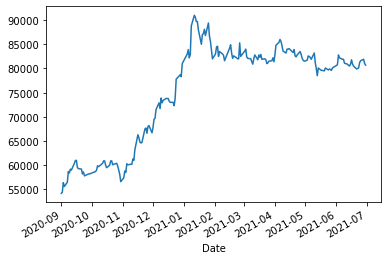

In [102]:
ss.Close.plot()

### obv 지표 이용

In [78]:
df = yf.download ('003540.KS', start ="2020-12-01", end ="2021-11-30" )
df['Date'] = df.index
df.head

[*********************100%***********************]  1 of 1 completed


<bound method NDFrame.head of                Open     High      Low    Close     Adj Close  Volume  \
Date                                                                   
2020-12-01  13850.0  13950.0  13800.0  13950.0  12783.449219  135713   
2020-12-02  14000.0  14150.0  13850.0  14000.0  12829.268555  202710   
2020-12-03  13950.0  13950.0  13800.0  13900.0  12737.630859   90096   
2020-12-04  14000.0  14200.0  13850.0  14000.0  12829.268555  205567   
2020-12-07  14100.0  14100.0  13700.0  13750.0  12600.173828  132441   
...             ...      ...      ...      ...           ...     ...   
2021-11-23  19900.0  20000.0  19800.0  19950.0  19950.000000   46659   
2021-11-24  19950.0  20100.0  19800.0  20100.0  20100.000000  101233   
2021-11-25  19950.0  20050.0  19800.0  19900.0  19900.000000   44065   
2021-11-26  19900.0  19900.0  19500.0  19500.0  19500.000000   97030   
2021-11-29  19100.0  19350.0  18800.0  19050.0  19050.000000  144379   

                 Date  
Date     

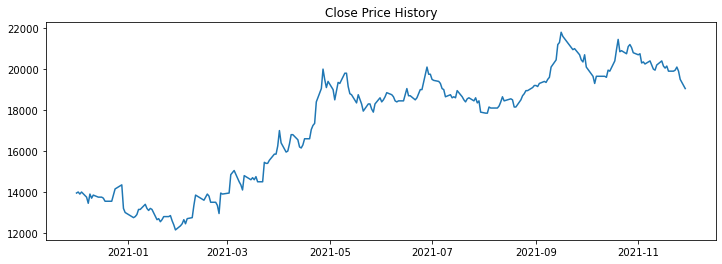

In [79]:
plt.figure(figsize=(12,4))
plt.plot( df['Close'])
plt.title('Close Price History')
plt.show()

In [80]:
OBV=[]
OBV.append(0)
for i in range (1, len(df.Close)):
    if df.Close[i] > df.Close[i-1]:
        OBV.append(OBV[-1] + df.Volume[i])
    elif df.Close[i] < df.Close[i-1]:
        OBV.append(OBV[-1] - df.Volume[i])
    else:
        OBV.append(OBV[-1] )


In [81]:
df['0BV']=OBV
df['OBV_EMA'] = df['0BV'].ewm(com=20).mean()
df

,Open,High,Low,Close,Adj Close,Volume,Date,0BV,OBV_EMA
Date,,,,,,,,,
2020-12-01,13850.0,13950.0,13800.0,13950.0,12783.449219,135713,2020-12-01,0,0.000000e+00
2020-12-02,14000.0,14150.0,13850.0,14000.0,12829.268555,202710,2020-12-02,202710,1.038271e+05
2020-12-03,13950.0,13950.0,13800.0,13900.0,12737.630859,90096,2020-12-03,112614,1.069001e+05
2020-12-04,14000.0,14200.0,13850.0,14000.0,12829.268555,205567,2020-12-04,318181,1.636465e+05
2020-12-07,14100.0,14100.0,13700.0,13750.0,12600.173828,132441,2020-12-07,185740,1.685065e+05
...,...,...,...,...,...,...,...,...,...
2021-11-23,19900.0,20000.0,19800.0,19950.0,19950.000000,46659,2021-11-23,5580732,5.639385e+06
2021-11-24,19950.0,20100.0,19800.0,20100.0,20100.000000,101233,2021-11-24,5681965,5.641412e+06
2021-11-25,19950.0,20050.0,19800.0,19900.0,19900.000000,44065,2021-11-25,5637900,5.641245e+06


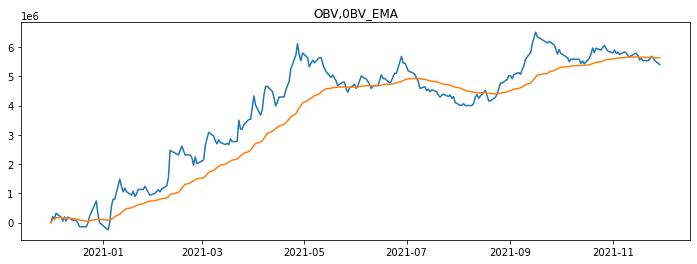

In [82]:
plt.figure(figsize=(12,4))
plt.plot( df['0BV'] ,label='OBV')
plt.plot(df['OBV_EMA'] ,label='OBV_EMA')
plt.title('OBV,0BV_EMA')
plt.show()

In [83]:
def buy_sell(signal,col1,col2):
    sigPriceBuy= []
    sigPriceSell=[]
    flag = -1 
    for i in range(0,len(signal)):
        
        if signal[col1][i]>signal[col2][i] and flag !=1:
            sigPriceBuy.append(signal['Close'][i])
            sigPriceSell.append(np.nan)
            flag=1
            
            
        elif signal[col1][i]<signal[col2][i] and flag !=0:
            sigPriceSell.append(signal['Close'][i])
            sigPriceBuy.append(np.nan)
            flag=0
            
        else:
            sigPriceBuy.append(np.nan)
            sigPriceSell.append(np.nan)
    
    return(sigPriceBuy,sigPriceSell)
            


In [84]:
x= buy_sell(df,'0BV','OBV_EMA')
df['Buy_Signal_Price']=x[0]
df['SelI_Signal_Price']=x[1]
df

,Open,High,Low,Close,Adj Close,Volume,Date,0BV,OBV_EMA,Buy_Signal_Price,SelI_Signal_Price
Date,,,,,,,,,,,
2020-12-01,13850.0,13950.0,13800.0,13950.0,12783.449219,135713,2020-12-01,0,0.000000e+00,NaN,NaN
2020-12-02,14000.0,14150.0,13850.0,14000.0,12829.268555,202710,2020-12-02,202710,1.038271e+05,14000.0,NaN
2020-12-03,13950.0,13950.0,13800.0,13900.0,12737.630859,90096,2020-12-03,112614,1.069001e+05,NaN,NaN
2020-12-04,14000.0,14200.0,13850.0,14000.0,12829.268555,205567,2020-12-04,318181,1.636465e+05,NaN,NaN
2020-12-07,14100.0,14100.0,13700.0,13750.0,12600.173828,132441,2020-12-07,185740,1.685065e+05,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2021-11-23,19900.0,20000.0,19800.0,19950.0,19950.000000,46659,2021-11-23,5580732,5.639385e+06,NaN,NaN
2021-11-24,19950.0,20100.0,19800.0,20100.0,20100.000000,101233,2021-11-24,5681965,5.641412e+06,20100.0,NaN
2021-11-25,19950.0,20050.0,19800.0,19900.0,19900.000000,44065,2021-11-25,5637900,5.641245e+06,NaN,19900.0


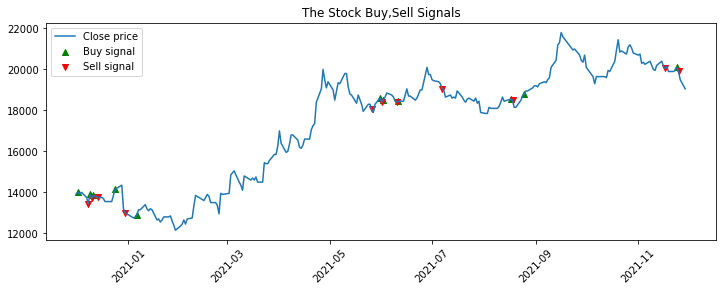

In [85]:
plt.figure(figsize =(12,4))
plt.scatter(df.index, df['Buy_Signal_Price'], color='green',label='Buy signal',marker='^',alpha=1)
plt.scatter(df.index, df['SelI_Signal_Price'],color='red',label='Sell signal',marker='v',alpha=1)
plt.plot(df['Close'],label= 'Close price')
plt.xticks(rotation = 45)
plt.title('The Stock Buy,Sell Signals')
plt.legend(loc='upper left')
plt.show()